# A Gentle Primer on Mixup & Label Smoothing

#### Last Time
[Most recently](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10_augmentation_my_reimplementation.ipynb?flush_cache=true) we took a detailed look at how random crop and resize, dihedral, perspective warp, and rotation image transforms work. And we implemented our own versions of each from scratch using [Pillow](https://pillow.readthedocs.io/en/stable/). We closed out our image augmentation journey by using PyTorch JIT to implement an GPU-optimized image rotation transform that was able to apply random rotations to all of a mini-batch's images, in parallel. 

I then went [one step further](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true) and figured out how to use NVIDIA's [DALI](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/index.html) library to build a batch image augmentation pipeline that works with the `Learner` class we implemented back in [notebook 09](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/09_optimizers_my_reimplementation.ipynb?flush_cache=true#Getting-rid-of-the-Runner-class). It turned out that DALI could process mini-batches sightly faster than JIT, and its concise Python API was much easier to work with than JIT. DALI's most notable negative was that some of its transforms, such as [warp affine](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#warpaffine), don't support randomization.

#### Mixup & Label Smoothing
Here we'll take some time to explore the regularization techniques of mixup and label smoothing. [Proposed](https://arxiv.org/abs/1710.09412) by Zhang et. al. in 2017, mixup literally combines pairs of images, as well as their labels, and uses these motley images/labels to train a model. For example, if we were training an image classifier on the [Imagenette](https://github.com/fastai/imagenette) dataset, mixup might create a new image by taking 30% of an image of a golfball and combining it with 70% of an image of a french horn. This new image's label would also be 30% golfball plus 70% french horn. Jeremy Howard has remarked that he's found mixup to oftentimes be just *as effective* as the more traditional types of image augmentation like rotations and perspective warps, to such an extent that using mixup as the sole form of image augmentation can be quite sufficient.

Seeing as how the goal of mixup is to add some noise to our data and labels, mixup is most effective when used in tandem with another technique that's designed to improve performance when labels are noisy. This technique, called label smoothing, was [proposed](https://arxiv.org/abs/1512.00567) by Szegedy et. al. in 2015, and it forces models to be *less sure* of their predictions by capping maximum possible value or probability of a positive prediction. What this means is that instead of it being possible for a model to predict that there is a probability of 1.0 that an object in an image is a french horn, the most "positive" we'll allow our model to get will always be 1.0 - ε, where ε is a small positive value such as 0.1.

#### Attribution
Virtually all the code that appears in this notebook is the creation of [Sylvain Gugger](https://www.fast.ai/about/#sylvain) and [Jeremy Howard](https://www.fast.ai/about/#jeremy). The original version of this notebook that they made for the course lecture can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/10b_mixup_label_smoothing.ipynb). I simply re-typed, line-by-line, the pieces of logic necessary to implement the functionality that their notebook demonstrated. In some cases I changed the order of code cells and or variable names so as to fit an organization and style that seemed more intuitive to me. Any and all mistakes are my own.

On the other hand, all long-form text explanations in this notebook are solely my own creation. Writing extensive descriptions of the concepts and code in plain and simple English forces me to make sure that I actually understand how they work.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#export
from exports.nb_10 import *

As has been the case for our last few notebooks, we'll use full-size Imagenette images to test out our implementations.

In [3]:
path = datasets.untar_data(imagenette_url)

Let's use the handy-dandy datablock API that we built from scratch back in [notebook 8](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb?flush_cache=true) to prepare the Imagenette images and labels for training.

In [4]:
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

data = (ImageList.from_files(path, tfms=tfms)
        .to_split(partial(grandparent_splitter, valid_name='val'))
        .to_label(parent_labeler, y_processor=CategoryProcessor())
        .to_databunch(bs, channels_in=3, channels_out=10, num_workers=4))

### Simple illustration of how mixup works

Let's "mixup" two images from the Imagenette training set. We'll take 45% of the first image (a parachute) and glue it together with 55% of the second image (a tench).

In [5]:
im1 = data.train_ds.x[0]
im2 = data.train_ds.x[4000]

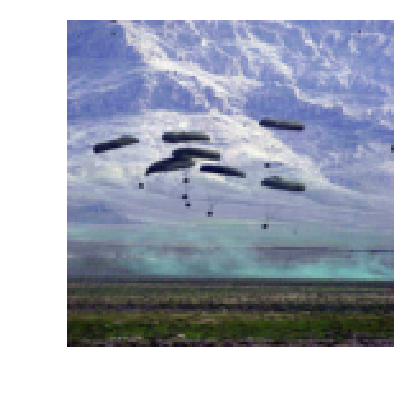

In [6]:
show_image(im1.permute(1,2,0))

In [7]:
label_im1 = data.train_ds.y[0]
label_im1

0

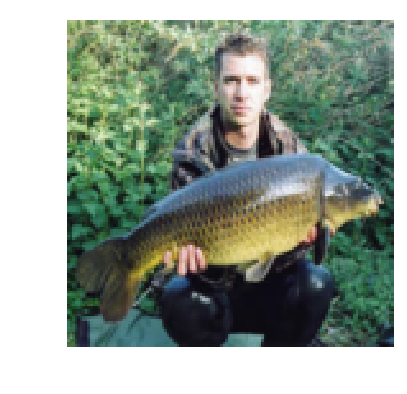

In [8]:
show_image(im2.permute(1,2,0))

In [9]:
label_im2 = data.train_ds.y[4000]
label_im2

3

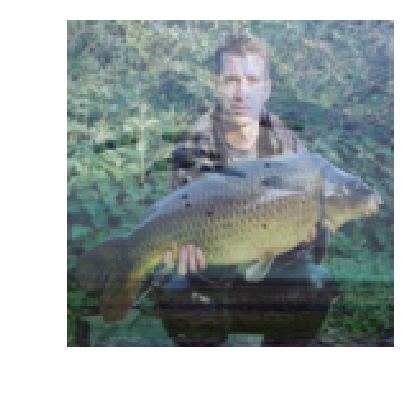

In [10]:
mixed_up = im1 * 0.45 + im2 * 0.55
show_image(mixed_up.permute(1,2,0))

Sure enough, the "mixed up" image still shows our guy holding his tench, but with hints of parachutes breaking through.

### Implementing mixup from scratch
The first thing we'll have to figure out is what's the best way to mix two images together? Specifically, how will we know how much of image one should be mixed with how much of image two? And, should each mixed-up image pair use the same recipe, or should the composition vary?

The mixup paper recommends picking a fraction, $t$, at random from between zero and one at the beginning of each batch. The two images in each image pair in a batch will be mixed together with proportions $t$ and $1-t$, respectively.

As for how the fraction $t$ is chosen, the authors select it from a [Beta Distribution](http://varianceexplained.org/statistics/beta_distribution_and_baseball/) with an $\alpha$ parameter value of `0.4`.

#### What on earth is a *Beta Distribution*?
At the core of the beta distribution is a factorial function that's called the *gamma function*. And although it is a factorial function, the gamma function does a good job of filling in the non-integer values in between each integer's factorials.

In [12]:
Γ = lambda x: x.lgamma().exp() # PyTorch only has a log-gamma func

Here's what the gamma function looks like:

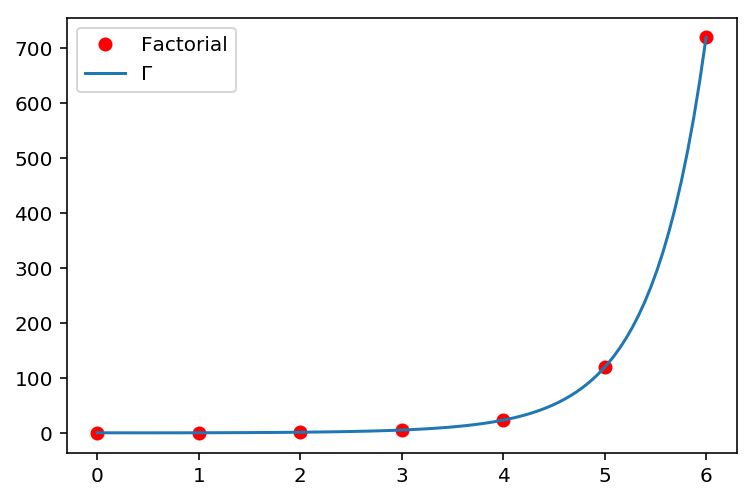

In [13]:
factorials = [math.factorial(i) for i in range(7)]
plt.plot(range(7), factorials, 'ro')
plt.plot(torch.linspace(0,6).numpy(), Γ(torch.linspace(0,6) + 1).numpy())
plt.legend(['Factorial', 'Γ']);

And here are some beta distributions for various values of α:

In [14]:
def beta_dist(x, α):
    return (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))

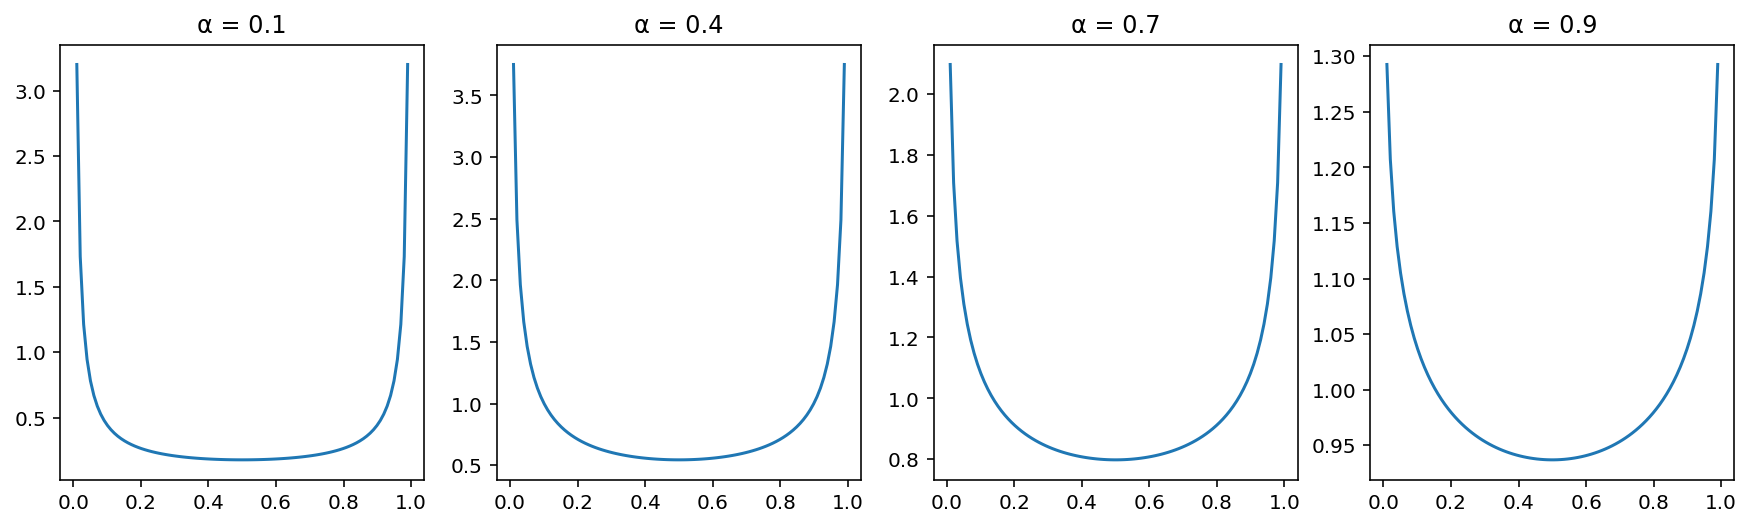

In [15]:
_, axs = plt.subplots(1, 4, figsize=(15,4))
x = torch.linspace(0, 1, 100)
for α, ax in zip([0.1, 0.4, 0.7, 0.9], axs):
    α = tensor(α)
    y = beta_dist(x, α)
    ax.plot(x.numpy(), y.numpy())
    ax.set_title(f"α = {α:.1}")

Notice that as α increases, the beta distribution's bottom gets more rounded, and more narrower - the chance of randomly drawing a value that's further removed from the extremes 0. and 1. also *increases*.

Using a beta distribution with an α of `0.4` gives a nice balance: we're unlikely to draw a fraction $t$ that's an extreme value close 0.0 or 1.0. We can expect to have lots of batches where we are creating mixed up images at ratios in the vicinity of 0.2/0.8, 0.3/0.7, 0.4/0.6, and 0.5/0.5.

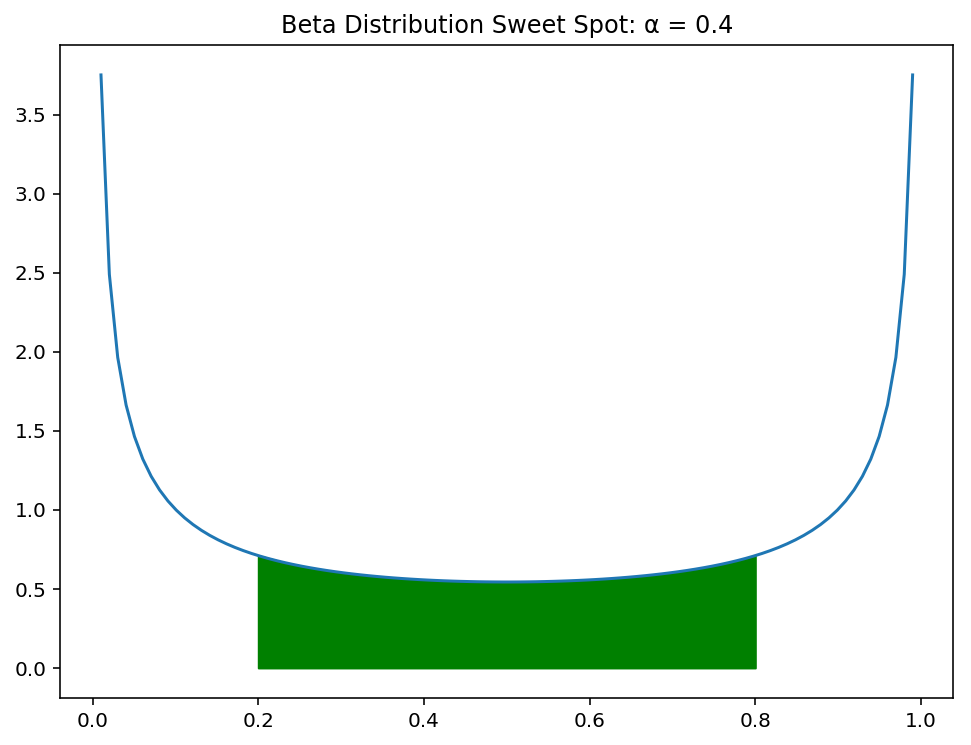

In [16]:
α = tensor(0.4)
plt.figure(figsize=(8,6))
plt.plot(x.numpy(), beta_dist(x, α).numpy())
plt.fill_between(torch.linspace(0.2,0.8, 20),
                 beta_dist(torch.linspace(0.2,0.8, 20), α),
                 color='green');
plt.title('Beta Distribution Sweet Spot: α = 0.4');

#### How to actually mix up all the images?
The authors of the mixup paper recommend using two dataloaders to return two separate batches at each iteration. Their images will be mixed into pairs by combining $t$% of the first loader's batch's images with $(t-1)$% of their counterparts in the second loader's batch.

Loading in two batches for each iteration will increase the amount of time it takes to train our model? Why? We'll have to perform image augmentations and transforms on *twice* the number of images at each iteration.

But fear not, there's a workaround we can employ, which the authors do also suggest in the paper. We can use one dataloader and load in only one batch, and then shuffle it and mix half of its images into pairs with images from the other half of the batch. This way, we can keep the same batch size of mixed up training images, but only run half the augmentations/transforms that we'd have to run if we loaded in two completely separate batches of individual images using two dataloaders.

#### How to mix up the labels? Authors use one-hot encoding
We've got images squared away, but we still need to know how we'll mixup their labels. The authors' approach was to one-hot encode each new mixed up image's label. What exactly does this look like? The two categories that are included in the new, composite image each get a 1, and all other categories have a 0. In the case of our earlier example that combined parachutes with a tench, the one-hot encoded label would be a list with 1s at the indices that belong to the parachute category (index 0) and the tench category (index 3), and 0s at the other eight indices.

#### Why it's good to avoid one-hot encoding
In notebook 03, I gave a [detailed explanation](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/03_minibatch_training_my_reimplementation.ipynb#To-one-hot-encode-or-not-to-one-hot-encode) as to why it's good to avoid using one-hot encoded labels whenever possible. The gist of it was that by using integer array indexing, we can simplify a single image's cross entropy loss formula from: $$-\sum_{i=1}^{n}{x_{i}\log{\left(p_{i}(x)\right)}}$$ to a much simpler: $$-\log{\left(p_{i}(x)\right)}$$ 

Effectively removing the need to compute a bunch of products and sum them all. 

#### Mixing up the labels without one-hot encoding
If we assume that our loss function will be categorical cross-entropy, we can get away with not one-hot encoding anything at all. Remember that if an image is 45% parachute and 55% tench, we ideally want our model to predict a 45% probability that the image is a parachute, and a 55% probability that the image is a tench. An easy way to wire this requirement into our loss function is to make two separate categorical cross-entropy loss calculations:

1. The first loss is between our model's output and the target of the first component of our mixed up image (a parachute in our previous example). 
2. A second loss is computed between the model output and the target belonging to the second component of the mixed up image (the tench). 

(Note that we use integer array indexing to compute the above two losses.) 

Our final loss is then a linear combination of the two losses, proportional to the degree to which each of the two individual images is represented in the mixed up image:

```python
loss(output, mixed_up_target) = t * loss(output, target1) + (1-t) * loss(output, target2)
```

In our example with parachute and tench images, the formula would be like this:

```python
loss(output, mixed_up_target) = 0.45 * loss(output, parachute) + 0.55 * loss(output, tench)
```

#### One other speed trick: varying $t$ during a batch
While the paper authors use the same value of $t$ for creating all mixed up images in a single batch, Jeremy and Sylvain found that models can train sooner if a different $t$ is used when creating each mixed up image from one batch. Note that we're not talking about an improvement in final accuracy here, just a speed improvement.

The only downside to picking a different $t$ at random for each image pair is that we may inadvertently create some duplicates. And if we have too many duplicate pairs, accuracy *will* diminish. To illustrate, say we have two images `image0` and `image1`. After shuffling, there is a chance that we might create two image pairs where the first is `image0` mixed with `image1`, and the second is `image1` mixed with `image0`:

```
t * image0 + (1-t) * image1
t * image1 + (1-t) * image0
```

Now, since we're choosing a different $t$ for each pair, there's a chance we might get more unlucky still, and choose a value of `0.1` for $t$ for the first pair, and a value of `0.9` for $t$ for the second pair:

```
0.1 * image0 + 0.9 * image1
0.9 * image1 + 0.1 * image0
```

If this happens, we will end up with two identical image pairs: each will have 90% of `image1` and 10% of `image0`. In order to avoid the accuracy drop that will accompany the presence of too many duplicate pairs, we need to come up with some way to avoid their creation in the first place.

The addition of one simple piece of logic can handily accomplish this: we can ensure that the first image in any image pair makes the bigest contribution to the final mixed up image. If we choose $t$ such that
```python
t = max(t, 1-t)
```
we'll avoid duplicate pair scenarios similar to what we illustrated just above. There may still be a handful of times when we choose a $t$ of `0.5` for two image pairs that have the same images, which would indeed cause our batch to have duplicates. However, the chance of choosing a $t$ of `0.5` from a beta distribution with an α of `0.4` is small enough that even if we did have some duplicates, they would be happen too infrequently to affect our model's accuracy.

#### A final wrinkle: the need for a context manager
The trickiest part of implementing mixup is handling the loss function.

Some loss functions, like PyTorch's [implementation](https://pytorch.org/docs/stable/nn.html#crossentropyloss) of categorical cross entropy, give practitioners the freedom to decide whether or not to include a reduction function. By default, `nn.CrossEntropy()` uses a mean reduction. In this default case, cross entropy loss is first calculated for each image in the batch. These individual losses are then averaged together, and this average loss is backpropagated across the network's layers in order to derive weight updates once a training iteration has completed.

Other loss function implementations have no concept of reduction. We would ideally like to be able to use any kind of loss function with our mixup implementation. So in order to accomplish this, the first thing we'll do is create a context manager. 

The context manager will check to see if a loss function has an attribute called `reduction`. If it does, we'll hold off on applying the reduction until we're ready to compute our final loss (remember, our final loss when using mixup is a linear combination of the two losses: between our model's prediction and the ground truth labels of both classes that comprise the mixed up image). If no reduction is ever used for a particular loss function, then we obviously won't need to worry about using a reduction when computing the final loss.

In [17]:
#export
class NoneReduce():
    def __init__(self, loss_func):
        self.loss_func, self.old_reduction = loss_func, None
        
    def __enter__(self):
        # If the chosen loss function has a reduction, we want to 
        # hold off on using it until we're ready to compute the 
        # mixed up image's composite loss. So we temporarily change
        # its reduction to 'none'. Only applicable when in training.
        if hasattr(self.loss_func, 'reduction'):
            self.old_reduction = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
    
    def __exit__(self, type, value, traceback):
        # Restore the loss function's reduction back to its original 
        # specification (if we had changed it to 'none' during training).
        if self.old_reduction is not None: 
            setattr(self.loss_func, 'reduction', self.old_reduction)

In [18]:
#export
from torch.distributions.beta import Beta

# Helper function to add to a tensor new, empty axes at specified dimensions.
def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def linear_comb(a, b, t): return t*a + (1-t)*b

# Helper function to finally apply our loss reduction during training 
# when we're good and ready -- after we've computed loss1 and loss2 
# for each mixed up image.
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [19]:
#export
class MixUp(Callback):
    _order = 90 # Ensure that this runs after normalization and Cuda callbacks
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
        
    def begin_fit(self):
        # Keep track of the loss function that we *had* been using
        # before training began, which wouldn't have yet had its 
        # reduction switched to 'none'.
        self.old_loss_func = self.run.loss_func
        # Set the training loop loss function to this class'
        # self.loss_func() method (defined just below).
        self.run.loss_func = self.loss_func
        
    def begin_batch(self):
        # Only perform mixup during training.
        if not self.in_train: return
        t = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        t = torch.stack([t, 1-t],1)
        self.t = unsqueeze(t.max(1)[0], (1,2,3))
        # Generate a list of random indices; includes each index in
        # the batch.
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1, self.yb1 = self.xb[shuffle], self.yb[shuffle]
        # Create mixed up images
        self.run.xb = linear_comb(self.xb, xb1, self.t)
        
    # After training, switch the loss function back to the 
    # version of the loss function that doesn't have it's
    # reduction attribute switched to 'none'.
    def after_fit(self): self.run.loss_func = self.old_loss_func
        
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = linear_comb(loss1, loss2, self.t)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

Now let's train a simple CNN and test it out:

In [20]:
min_lr=3e-1
n_outs = [64, 64, 128, 256] 
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(min_lr, 3*min_lr, min_lr))
scheduler = ParamScheduler('lr', phases)

callback_funcs = [partial(AvgStatsCallback, accuracy),
                  CudaCallback,
                  ProgressBarCallback,
                  partial(BatchTransformXCallback, norm_imagenette),
                  MixUp]

In [23]:
learn = get_learner(n_outs, data, lr=min_lr, layer=conv_layer, callback_funcs=callback_funcs)

In [24]:
learn.fit(8, scheduler)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.936738,0.379634,1.723136,0.410000,00:41
1,1.741205,0.488444,1.648743,0.456000,00:41
2,1.595122,0.565302,1.730474,0.458000,00:40
3,1.448789,0.641926,1.004074,0.688000,00:40
4,1.345074,0.697456,0.913907,0.714000,00:41
5,1.255411,0.742438,0.852384,0.740000,00:40
6,1.183081,0.785792,0.829072,0.760000,00:41
7,1.102141,0.825655,0.842681,0.754000,00:41


This is a better validation accuracy score than I saw after training the same model for 8 epochs using with a [DALI pipeline](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true#Bonus:-horizontal-flip-transform-experiment) that had four, more traditional, types of image augmentations (such as rotate, flips).

This perfectly illustrates how having mixup, alone, can often be better than having a bunch of image augmentations!

### Label Smoothing
Recall that when using Mixup, our final training loss for each mixed up image pair is a linear combination of two separate losses: they are the losses between the model's prediction and the two images' original targets. Formulating the final loss as a linear combination that represents the degree to which each of the two images is represented in the final, mixed up image, is how we encourage our model to split its prediction between these two image categories that are represented in a mixed up image. We definitely don't want our model to ever make the mistake of strongly predicting a single category label for a mixed up training image that has really has two category labels.

The label smoothing technique is an additional way we can modify our cross entropy loss function, so as to encourage our model to be less likely to swing too far toward predicting one category instead of two: 

We essentially will force our model to be less "certain" about *any* prediction it makes for any category. We want our model to be a little bit uncertain about predicting that a certain category is not represented in an image. At the same time, we also want our model to be a little uncertain about predicting that a certain category is represented in an image. This is accomplished by setting a maximum cap on the amount of certaintity a model can have for an in-category prediction -- instead of `1.0`, the strongest prediction a model can make for any category will now be `1-ε`, where ε is a small positive number, like `0.1`. Correspondingly, the minimum out-of-category prediction that a model can now make will no longer be `0.0`, but will be `ε`, instead.

The formula for label smoothing cross entropy loss of a single image $x$ is $$\epsilon*\frac{\sum_{j=1}^{n}-\log{\left(p_{j}(x)\right)}}{n} + (1-\epsilon)*(-\log{\left(p_{i}(x)\right)})$$ where $p_{i}(x)$ is the model's prediction that the image belongs to the ground-truth class $n$ is the total number of classes. The first term, which is multiplied by ε, is the average the model's log softmax predictions across each of the $n$ classes, $j$.

In [25]:
#export
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε, self.reduction = ε, reduction
        
    def forward(self, output, target):
        num_classes = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        # Reduce loss if self.reduction is not 'none'
        # For MixUp, during training self.reduction will be 'none'.
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_comb(loss/num_classes, nll, self.ε)

Note that we include a reduction attribute in our implemention of `LabelSmoothingCrossEntropy`, so that works well with our `MixUp` class.

Let's train one more mix up model, this time using our cross entropy loss function that's been enhanced with label smoothing:

In [26]:
learn = get_learner(n_outs, data, lr=min_lr, layer=conv_layer, loss_func = LabelSmoothingCrossEntropy(), callback_funcs=callback_funcs)

In [27]:
learn.fit(8, scheduler)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.008980,0.376532,1.704944,0.498000,00:40
1,1.814030,0.516519,2.161061,0.426000,00:40
2,1.674110,0.600512,1.412247,0.616000,00:40
3,1.580290,0.663487,1.294374,0.670000,00:40
4,1.509189,0.706918,1.203658,0.722000,00:40
5,1.438734,0.753761,1.175912,0.714000,00:41
6,1.373167,0.802234,1.184649,0.722000,00:40
7,1.322376,0.836203,1.141823,0.728000,00:41


In this case, adding label smoothing *does not* improve our mixup model's accuracy!

Also, a quick sanity check to ensure that our cross entropy loss function's `reduction` attribute has been returned to its original value (`'mean'`) after training has ended (was changed to `'none'` during training):

In [28]:
assert learn.loss_func.reduction == 'mean'

### Export

In [29]:
nb_auto_export()

<IPython.core.display.Javascript object>